In [1]:
# Importing libraries
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import utilities as utils

from tqdm import tqdm # to compute the time bar

In [2]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Computing High-Order Couplings

In this notebook we will present an implementation of the mapping between a Restricted Boltzmann Machine (RBM) and a Potts Model with multi-body interactions.


<p align="center">
<img src="https://github.com/DsysDML/couplings_inference/blob/main/figures/RBM_figure.png?raw=true" alt="RBM figure" width="50%">
</p>

**Fig-1. Architecture of the Potts-Bernoulli Restricted Boltzmann Machine (PB-RBM).** Hidden variables $h_a$ can take only two possible values, while visible variables $v_i$ take on $q$ different states or colors.

## Introduction

The RBM is an energy-based model estructured as bipartite neural network. In this model, the visible layer $\boldsymbol{v} \!=\! \{ v_i \}_{i=1}^{N_v}$ represents the data, while the hidden layer $\boldsymbol{h} \!=\! \{ h_i \}_{i=1}^{N_h}$ accounts the interactions among the visible variables. The probability of a given RBM configuration $\{ \boldsymbol{v}, \boldsymbol{h} \}$ is determined by the Boltzmann distribution i.,e.
$$
p(\boldsymbol{v}, \boldsymbol{h}) \!\propto\! e^{-\mathcal{H}(\boldsymbol{v}, \boldsymbol{h})},
$$
where $\mathcal{H} (\boldsymbol{v}, \boldsymbol{h})$ is the _energy function_ or _Hamiltonian_. Here, we define the hidden nodes as Bernoulli variables, i.e., $h_a \!\in\! \{0,1\}$, and visible nodes as categorical variables, or Potts "spins", which can take on $q$ states, i.e., $v_i \!\in\! \{1, \dots, q \}$. Hence, the Hamiltonian of such a model is 

$$
\mathcal{H}(\boldsymbol{v}, \boldsymbol{h}) = -\sum_{i, a, \mu} W_{ia}^{\mu} h_a \delta_{\mu}^{v_i} - \sum_{i, \mu} b_{i}^{\mu} \delta_{\mu}^{v_i} - \sum_{a} c_a h_a.
\tag{1}
$$

In the above we used $\delta$ to denote the Kronecker delta, and $\boldsymbol{\Theta} \!\equiv\! \{ \boldsymbol{W}, \boldsymbol{b}, \boldsymbol{c} \}$ are the model parameters. Marginalizing Eq. (1) one can obtain the following Hamiltonian:

$$
\mathcal{H}(\boldsymbol{v}) =  - \sum_{i,\mu} b_i^\mu \delta_\mu^{v_i} - \sum_a \ln \left(1 + e^{ c_a + \sum_{i, \mu} W_{ia}^{\mu} \delta_\mu^{v_i}} \right).
\tag{2}
$$

In the Ref. [1], we expanded Eq. (2) as

$$
\mathcal{H} (\boldsymbol{v}) 
= - \sum_{i, \mu} H_i^\mu \delta_\mu^{v_i} - \sum_{1 \le i_1 < i_2 \le N_v} \sum_{\mu_1, \mu_2} \! \! J_{ i_1 i_2}^{\mu_1 \mu_2} \delta_{\mu_1}^{v_{i_1}} \delta_{\mu_2}^{v_{i_2}} + \sum_{1 \le i_1 < i_2 < i_3 \le N_v} \sum_{\mu_1, \mu_2, \mu_3} J_{ i_1 i_2 i_3}^{\mu_1 \mu_2 \mu_3} \delta_{\mu_1}^{v_{i_1}} \delta_{\mu_2}^{v_{i_2}} \delta_{\mu_3}^{v_{i_3}} \dots,
$$

with effective couplings (in the zero-sum gauge) given by

$$
J_{i_1 \dots i_n}^{\mu_1 \dots \mu_n}  
    = \sum_{K \subseteq [n] } (-1)^{n - |K|} \Bigg[
    \frac{1}{q^{N_v}} \sum_{\mu'_1, \dots, \mu'_{N_v}} \sum_a  
     \ln \left( 1 + e^{c_a +  \sum_{ k \in K } W_{i_k a}^{\mu_k} + \sum_{ l \in [N_v] \setminus K} W_{i_l a}^{\mu'_l} } \right) \Bigg],
\tag{3}
$$

where introduced $[N] \equiv \{1,2, \dots, N \}$. Note that Eq. (3) introduces sums of $q^N$ terms, which cannot be done exactly, so we must rely on approximations of such expressions. Thus, We can rewrite Eq. (3) as

$$
J_{i_1 \dots i_n}^{\mu_1 \dots \mu_n}  = \sum_{K \subseteq [n]} (-1)^{n-|K|} \frac{1}{q^n} \sum_{\mu'_1, \dots, \mu'_n} \sum_{a} \mathbb{E}_{x \sim X_a^{\left(i_1 \dots i_n \right)}} \left[ \ln \left( 1 + e^{c_a + \sum_{k \in K} W_{i_k a}^{\mu_k} + \sum_{l \in [n] \setminus K} W_{i_l a}^{\mu'_l} + x  } \right)  \right],
\tag{4}
$$

defining $X_{a}^{(i_1, \dots, i_n)} \equiv \sum_{k=n+1}^{N_v} \! W_{i_k a}^\ast$, where each $W_{i_k a}^\ast$ is a random variable uniformly distributed over $\big\{W_{i_k a}^\mu \!:\! \mu \!\in\! [q] \big\}$. According to the Central Limit Theorem if $N_v \gg n$ then $X_{a}^{(i_1, \dots, i_n)} \to \mathcal{N}(0, \sigma)$, with $\sigma = \left[ q^{-1} \sum_{k=n+1}^{N_v} \sum_{\mu=1}^q W_{i_k a}^{\mu} \right]^{\frac{1}{2}}$. Hence, for a sufficiently large $N_v$ and low $n$ we can approximate the expected value in Eq. (4) with the following interal:

$$
\mathbb{E}_{x \sim X_a^{\left(i_1 \dots i_n \right)}} \left[ \ln \left( 1 + e^{c_a + \sum_{k \in K} W_{i_k a}^{\mu_k} + \sum_{l \in [n] \setminus K} W_{i_l a}^{\mu'_l} + x  } \right)  \right] \approx \frac{1}{\sqrt{2\pi} \sigma } \int_{-\infty}^{\infty} dx \ e^{-\frac{x^2}{2 \sigma^2}} \ln \left( 1 + e^{ c_a + \sum_{ k \in K } W_{i_k a}^{\mu_k} + \sum_{ l \in [N_v] \setminus K} W_{i_l a}^{\mu'_l} + x } \right),
\tag{4.b}
$$

which can be computed numerically. 

Leveraging parallel computation in Graphics Proccessing Units we will use $(4.\mathrm{b})$ to compute effective couplings $J_{i_1 \dots i_n}^{\mu_1 \dots \mu_n}$ efficiently.

## Loading a PB-RBM model

Let us use an RBM model trained on Multiple Sequence Alignment data (PF00072) to test our functions.

In [3]:
model_fname = 'PottsBernoulliRBM_PCD-10_mbs=5000_lr=0.01_Nh=1000_centered.h5'

# selecting an update to observe
update = 51480
with h5py.File('models/'+ model_fname, 'r') as f:
    n_upd = f['UpdByEpoch'][()]
    ep = int(update/n_upd)
    W = f['W' + str(ep)][:,:,:].astype(np.float64)  # dim: q x Nv x Nh
    b = f['vbias' + str(ep)][:,:].astype(np.float64)  # dim: q x Nv
    c = f['hbias' + str(ep)][:].astype(np.float64)  # dim: Nh 

In [4]:
# RBM Fixing Gauge
def fix_gauge_RBM(W, b, c, gauge='zero-sum'):
    """
    a Function to fix the gauge in Potts-Bernoulli RBMs

    Parameters:
    - W: weight matrix (dim: q x Nv x Nh).
    - b: visible bias (dim: q x Nv).
    - c: hidden bias (dim: Nh).
    - gauge: name of the gauge that is going to be fixed. 
            It could be either 'zero-sum' or 'lattice-gas'.
    """

    if gauge == 'zero-sum':
        A = W.mean(axis=0)
        bt = b.mean(axis=0)

    elif gauge == 'lattice-gas':
        # the zero is set in the last color
        A = W[-1,:,:]
        bt= b[-1,:]
    else:
        return 'Gauge does not exist'
    
# it is important to fix the zero-sum gauge in the RBM to get accurate results!
fix_gauge_RBM(W, b, c)

## Torch Functions

Now we implement the functions we need to extract the couplings.

In [5]:
# auxiliary function to set the device of the RBM parameters
def set_device(W, b, c, cuda=True, cuda_device=torch.device('cuda:0')):
    """
    Set the device of RBM paramters.
    
    Parameters:
    - W, b, c: parameters of the RBM.
    - cuda: if true it uses cuda, otherwise it uses cpu.
    """
    
    if cuda and torch.cuda.is_available():
        device = cuda_device
    else:
        device = 'cpu'
    
    # loading model paraters
    W_torch = torch.from_numpy(W).to(device)
    b_torch = torch.from_numpy(b).to(device)
    c_torch = torch.from_numpy(c).to(device)
    
    return W_torch, b_torch, c_torch    

# Gaussian function in torch 
def gaussian(x, loc=0, scale=1):
    """
    It returns the value of a gaussian function.
    
    Parameters:
    - x: variable at which the gaussian function in evaluated.
    - loc: location parameter of the gaussian (a.k.a. the mean).
    - scale: scale parameter of the gaussian (a.k.a. the standard deviation).
    """
    pi = torch.tensor(math.pi, dtype=x.dtype, device=x.device)
    coeff = 1 / (scale * torch.sqrt(2*pi))
    exponent = -0.5*(((x - loc)/scale)**2)
    return coeff * torch.exp(exponent)

# softmax function in torch
def softplus(x):
    """
    It computes ln(1 + e^(x)).
    
    Parameters:
    - x: variable at which the function is evaluated.
    - b: bias of the function (typically the field plus the weights of sites in j_list).
    """
    return torch.log(1 + torch.exp(x))

# estimating the average using a numeric Gaussian integral
def est_gaussian_avg(f, bias, loc, scale, n_sigma, n_steps):
    """
    It uses the trapezoid rule of integration to approximate the average of a 
    function over a Gaussian meassure.
    
    parameters:
    - f: function to average.
    - loc: location parameter of the Gaussian (a.k.a. the mean).
    - scale: scale parameter of the gaussian (a.k.a. the standard deviation).
    - n_sigma: set the wide of the numerical integral in terms of the scale parameter of the gaussian.
    - n_steps: number of steps of the numerical integral.
    """
    # numerical integration
    beta = n_sigma*scale
    alpha = -beta
    h = (beta-alpha)/n_steps
    I = 0.5*(f(bias + alpha)*gaussian(alpha, loc, scale) 
             + f(bias + beta)*gaussian(beta, loc, scale))
    
    for k in range(1, n_steps):
        x = alpha + k*h
        I += f(bias + x)*gaussian(x, loc, scale)
    return torch.sum(h*I, dim=-1)

## Fields

From Eq. (4) we derive that formula for the fields:
$$
\begin{align*}
{J}_{i}^{\mu} 
&= \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 \right)}} \left [ \ln \left( 1 + e^{c_i + W_{i a}^{\mu} + x } \right) \right] - \frac{1}{q} \sum_{\mu'} \sum_a  \mathbb{E}_{x \sim X_a^{\left(i_1 \right)}}  \left [ \ln \left( 1 + e^{c_i + W_{ia}^{\mu'} + x} \right) \right].
\tag{5}
\end{align*}
$$

In [6]:
# fields functions
def E1_zs(W, c, n_sigma, n_steps):
    """
    It computes the first term of the r.h.s. of Eq. (5).
    
    Parameters:
    - W: weight matrix (dim: q x Nv x Nh)    
    - c: hidden fields (dim: Nh)
    - n_sigma: set the wide of the numerical integral in terms of the scale parameter of the gaussian.
    - n_steps: number of steps of the numerical integral.
    """
    q = W.shape[0]
    
    # bias of the softmax function
    bias = W + c

    # scale parameter of the Gaussian measure
    sd = torch.sqrt((torch.sum(W**2, dim=(0,1)) - torch.sum(W**2, dim=0))/q)

    return est_gaussian_avg(f=softplus, 
                            bias=bias, 
                            loc=0.0, scale=sd, 
                            n_sigma=n_sigma, 
                            n_steps=n_steps) # dim: q x Nv

def H_zs(W, b, c, n_sigma, n_steps):
    """
    It computes a q x Nv effective field matrix.
    
    Parameters:
    - W: weight matrix (dim: q x Nv x Nh)  
    - b: Visible fields (dim: q x Nv)
    - c: hidden fields (dim: Nh)
    - n_sigma: set the wide of the numerical integral in terms of the scale parameter of the gaussian.
    - n_steps: number of steps of the numerical integral.
    """
    E1_torch = E1_zs(W, c, n_sigma, n_steps)
    
    return (E1_torch - E1_torch.mean(dim=0) + b) # dim: q x Nvy

Note that in this case we need to add the visible bias $b_i^\mu$  plus the effective fields introduced by the visible variables $J_i^\mu$, whose formulas was given in Eq. $(5)$, to consider all the first-order contributions.

In [7]:
# RBM parameters
W_torch, b_torch, c_torch = set_device(W, b, c, cuda=True)

# parameters of numerical integral 
n_sigma = 5
n_steps = 20

In [8]:
%%timeit
h_torch = H_zs(W_torch, b_torch, c_torch, n_sigma, n_steps) # q x Nv
torch.cuda.synchronize()
#print(h_torch)

15.1 ms ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 2-Body Couplings

According to Eq. (4) the 2-body effective couplings are given by
$$
\begin{align*}
{J}_{i_1 i_2 }^{\mu_1 \mu_2} 
& =  \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 \right)}}  \left [ \ln \left( 1 + e^{c_a + W_{i a}^{\mu_1} + W_{i a}^{\mu_2} + x } \right) \right] - \frac{1}{q} \sum_{\mu'_1} \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 \right)}}  \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu'_1} + W_{i_2 a}^{\mu_2} + x } \right) \right] \\
& - \frac{1}{q} \sum_{\mu'_2} \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 \right)}}  \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu_1} + W_{i_2 a}^{\mu'_2} + x } \right) \right] + \frac{1}{q^2} \sum_{\mu'_1, \mu'_2} \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 \right)}}  \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu'_1} + W_{i_2 a}^{\mu'_2} + x } \right) \right]. 
\end{align*}
\tag{6}
$$

In [9]:
# 2-body couplings functions
def E2_zs(W, c, i1, i2, n_sigma, n_steps):
    """
    It computes the First term in the r.h.s. of (6).
    
    Parameters:
    - W: weight matrix (dim: q x Nv x Nh)    
    - c: hidden fields (dim: Nh)
    - i1, i2: visible site index 1, 2
    - n_sigma: set the wide of the numerical integral in terms of the scale parameter of the gaussian.
    - n_steps: number of steps of the numerical integral.
    """
    W1 = W[:,i1,:]
    W2 = W[:,i2,:]
    q = W.shape[0]

    # bias of the softmax function
    bias = W1.unsqueeze(1) + W2.unsqueeze(0) + c

    # scale parameter of the Gaussian measure
    sd = torch.sqrt((torch.sum(W**2, dim=(0,1)) 
                     - torch.sum(W1**2, dim=0)
                     - torch.sum(W2**2, dim=0)
                    )/q)
    
    return est_gaussian_avg(f=softplus, 
                            bias=bias, 
                            loc=0.0, scale=sd, 
                            n_sigma=n_sigma, 
                            n_steps=n_steps) # dim: q x q

def J2_zs(W, c, i1, i2, n_sigma, n_steps):
    """
    It computes the q x q 2-body coupling matrix.
    
    Parameters:
    - W: weight matrix (dim: q x Nv x Nh)    
    - c: hidden fields (dim: Nh)
    - i1, i2: visible site index 1, 2
    - n_sigma: set the wide of the numerical integral in terms of the scale parameter of the gaussian.
    - n_steps: number of steps of the numerical integral
    """
    E2_torch = E2_zs(W, c, i1, i2, n_sigma, n_steps)
    J2_torch = (E2_torch + E2_torch.mean()
                - E2_torch.mean(dim=0).unsqueeze(0) 
                - E2_torch.mean(dim=1).unsqueeze(1) 
               )
    
    return J2_torch # dim: q x q

In [10]:
# RBM parameters
W_torch, b_torch, c_torch = set_device(W, b, c, cuda=True)

# parameters of numerical integral 
n_sigma = 5
n_steps = 20

In [11]:
%%timeit
J2_torch = J2_zs(W_torch, c_torch, 2, 3, n_sigma, n_steps) # q x q
torch.cuda.synchronize()

4.51 ms ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
# computating all couplings
q, Nv, _ = W.shape
J2_matrix = np.zeros((q,q,Nv,Nv))
pbar = tqdm(total=int(Nv*(Nv-1)/2), colour='green')
for j1 in range(1, Nv):
    for j2 in range(j1):
        J2_torch = J2_zs(W_torch, c_torch, j1, j2, n_sigma, n_steps)
        J2_matrix[:,:, j1, j2] = J2_torch.to('cpu').numpy()
        pbar.update(1)
pbar.close()

J2_matrix = J2_matrix + J2_matrix.transpose(1,0,3,2)
# This cell runs in < 30s (in an NVIDIA Geforce RTX 3090 GPU)

100%|██████████| 6216/6216 [00:28<00:00, 221.07it/s]


## 3-body couplings

Hence, the formula for the 3-body couplings is given by

$$
\begin{align*}
{J}_{i_1 i_2 i_3 }^{\mu_1 \mu_2 \mu_3} 
&=  \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 i_3 \right)}} \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu_1} + W_{i_2 a}^{\mu_2} + W_{i_3 a}^{\mu_3} + x } \right) \right] 
- \frac{1}{q} \sum_{\mu'_1} \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 i_3 \right)}} \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu'_1} + W_{i_2 a}^{\mu_2} + W_{i_3 a}^{\mu_3} + x } \right) \right] \\
& - \frac{1}{q} \sum_{\mu'_2} \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 i_3 \right)}} \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu_1} + W_{i_2 a}^{\mu'_2} + W_{i_3 a}^{\mu_3} + x } \right) \right]
- \frac{1}{q} \sum_{\mu'_3} \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 i_3 \right)}} \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu_1} + W_{i_2 a}^{\mu_2} + W_{i_3 a}^{\mu'_3} + x } \right) \right]
\\ 
& + \frac{1}{q^2} \sum_{\mu'_2, \mu'_3} \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 i_3 \right)}} \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu_1} W_{i_2 a}^{\mu'_2} + W_{i_3 a}^{\mu'_3} + x } \right) \right] 
+ \frac{1}{q^2} \sum_{\mu'_1, \mu'_3} \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 i_3 \right)}} \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu'_1} + W_{i_2 a}^{\mu_2} + W_{i_3 a}^{\mu'_3} + x } \right) \right] \\
& + \frac{1}{q^2} \sum_{\mu'_1, \mu'_2} \sum_a \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 i_3 \right)}} \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu'_1} + W_{i_2 a}^{\mu'_2} + W_{i_3 a}^{\mu'_3} + x } \right) \right]
- \frac{1}{q^3} \sum_{\mu'_1, \mu'_2, \mu'_3} \sum_a  \mathbb{E}_{x \sim X_a^{\left(i_1 i_2 i_3 \right)}} \left [ \ln \left( 1 + e^{c_a + W_{i_1 a}^{\mu'_1} + W_{i_2 a}^{\mu'_2} + W_{i j_3}^{\mu'_3} + x } \right) \right]
\end{align*}
\tag{7}
$$

In [13]:
# 3-body couplings functions
def E3_zs(W, c, i1, i2, i3, n_sigma, n_steps):
    """
    It computes the First term in the r.h.s. of (7).
    
    Parameters:
    - W: weight matrix (dim: q x Nv x Nh).
    - c: hidden fields (dim: Nh).
    - i1, i2, i3: visible site index 1, 2, 3.
    - n_sigma: set the wide of the numerical integral in terms of the scale parameter of the gaussian.
    - n_steps: number of steps of the numerical integral.
    """
    W1 = W[:,i1,:]
    W2 = W[:,i2,:]
    W3 = W[:,i3,:]
    q = W.shape[0]

    # bias of the softmax function
    bias = (W1.unsqueeze(1).unsqueeze(1) 
            + W2.unsqueeze(1).unsqueeze(0) 
            + W3.unsqueeze(0).unsqueeze(0) 
            + c)

    # scale parameter of the Gaussian measure
    sd = torch.sqrt((torch.sum(W**2, dim=(0,1)) 
                      - torch.sum(W1**2, dim=0)
                      - torch.sum(W2**2, dim=0)
                      - torch.sum(W3**2, dim=0)
                     )/q)

    return est_gaussian_avg(f=softplus, 
                            bias=bias, 
                            loc=0.0, scale=sd, 
                            n_sigma=n_sigma, 
                            n_steps=n_steps) # dim: q x q x q

def J3_zs(W, c, i1, i2, i3, n_sigma, n_steps):
    """
    Compute the q x q x q 3-body coupling tensor.
    
    Parameters:
    - W: weight matrix (dim: q x Nv x Nh).
    - c: hidden fields (dim: Nh).
    - i1, i2, i3: visible site index 1, 2, 3.
    - n_sigma: set the wide of the numerical integral in terms of the scale parameter of the gaussian.
    - n_steps: number of steps of the numerical integral.
    """
    E3_torch = E3_zs(W, c, i1, i2, i3, n_sigma, n_steps)
    J3_torch = (E3_torch - E3_torch.mean()
                - E3_torch.mean(dim=0).unsqueeze(0) 
                - E3_torch.mean(dim=1).unsqueeze(1) 
                - E3_torch.mean(dim=2).unsqueeze(2) 
                + E3_torch.mean(dim=(1,2)).unsqueeze(1).unsqueeze(2)
                + E3_torch.mean(dim=(0,1)).unsqueeze(0).unsqueeze(1)
                + E3_torch.mean(dim=(0,2)).unsqueeze(0).unsqueeze(2)
               )
    
    return J3_torch # dim: q x q x q

In [14]:
# RBM parameters
W_torch, b_torch, c_torch = set_device(W, b, c, cuda=True)

# parameters of numerical integral 
n_sigma = 5
n_steps = 20
i1, i2, i3 = 109, 10, 30

In [15]:
%%timeit
# Computing 2-body coupling for a triplet (j1, j2, j3)
J3_torch = J3_zs(W_torch, c_torch, i1, i2, i3, n_sigma, n_steps)
torch.cuda.synchronize()

52.9 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Contact Prediction

Finally, we will use the inferred 2-body couplings to conduct a contact prediction analysis. We also compare our results with an state-of-the-art technique: **plmDCA** [2,3].

### Preliminaries

As is standard in DCA analysis, after inferring the 2-body epistatic couplings, we compute the coupling strength between two sites $i$ and $j$ as the Fröbenius norm of the corresponding coupling matrix, given by:

$$
F_{ij}^{(2)} = \sqrt{\sum_{\mu, \nu} \left( J_{ij}^{\mu \nu} \right)^2 }.
\tag{8}
$$

Then, we can achieve an ever better contact prediction performance by implementing the _average-product correction} (APC)_ :

$$
    F_{ij}^\mathrm{APC} = F_{ij}^{(2)} - \frac{\sum_k F_{ik}^{(2)} \sum_{k} F_{kj}^{(2)}}{\sum_{k,l}F_{kl}^{(2)}},
\tag{9}
$$

which intends to minimize any background noise.

In [16]:
# A function to compute the APC correction
def APC_correction(F):
    Nv = F.shape[0]
    a = F.sum(axis=1).reshape(Nv, 1)
    b = F.sum(axis=0).reshape(1, Nv)
    c = F.sum()
    APC = a*b/c

    return F - APC 

In [17]:
# Computing Fröbenius norm from inferred couplings
F2 = np.linalg.norm(J2_matrix[:20,:20,:,:], axis=(0,1))

# Now we apply the APC correction
F2_APC = APC_correction(F2)

# Converting the matrix into a table
F2_table = utils.matrix_to_table(F2_APC)

# customizing the table
F2_table = utils.custom_table(F2_table, ascending=False)

#F2_table.head()

In [18]:
# loading plmDCA scores
plm_table = pd.read_table(f'data/plmDCA_score_PF00072.txt', header=None)
plm_table.columns = ['i', 'j', 'Fplm']
plm_table = utils.custom_table(plm_table, ascending=False, zero_index = False)

#plm_table.head()

In [19]:
# loading residues distance data to test our prediction
distance_raw = pd.read_table('data/PF00072_struct.dat', delimiter=' ', header=None)

# customizing table
distance_table = distance_raw.drop(columns=[2])
distance_table.columns = ['i', 'j', 'r']

distance_table = utils.custom_table(distance_table, ascending=True,  zero_index = False)

#distance_table.head()

### Ploting Contacts

In [20]:
# setting the thresholds
k = 5 # minimum residue distance in the sequence (primary structure) of the protein
threshold = 7.5 # threshold to consider a contact

# creating a contact table

# first we add a column that tell us if the pair is a contac considering the threshold
contact_table = distance_table[['rank','|i-j|']].join(distance_table[['r']] < threshold)

# then we consider a epistatic contact only if the distance in the sequence is greater than k 
contact_table = utils.filter_seq_distance(contact_table, k=k)
num_contacts = contact_table['r'].values.sum()
num_total = int(Nv*(Nv-1)/2)

# we filter also pair whose distance in the sequece is greater than k
F2_table_mod = utils.filter_seq_distance(F2_table, k=k).join(contact_table[['r']])
plm_table_mod = utils.filter_seq_distance(plm_table, k=k).join(contact_table['r'])
print('# contacts:', num_contacts)

# contacts: 2074


100%|██████████| 300/300 [00:03<00:00, 95.20it/s] 


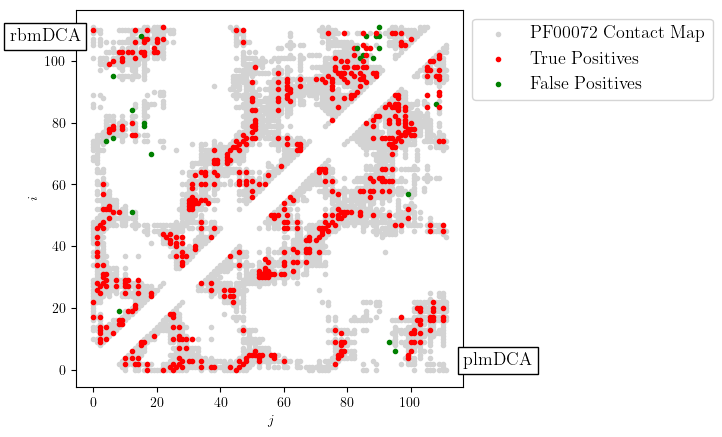

In [21]:
# Let us look at residues pairs with strongest Frobenius norm
num_contacts_F2 = 300

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

# setting couters to 0
num_F2 = 0
num_F2_false = 0
num_plm = 0
num_plm_false = 0

# plotting true contacts 
pbar = tqdm(total=num_contacts, colour='White')
for k in range(num_contacts):   
    i, j = contact_table.iloc[k].name
    ax.scatter(i, j, c='lightgray', marker='.', rasterized=True, label='PF00072 Contact Map')
    ax.scatter(j, i, c='lightgray', marker='.', rasterized=True)
    pbar.update(1)
pbar.close()

pbar = tqdm(total=num_contacts_F2, colour='green')
for k in range(num_contacts_F2):
    
    # plotting F2 prediction
    i0, j0 = F2_table_mod.iloc[k].name
    condition0 = contact_table.loc[(i0,j0)]['r']

    if condition0:
        ax.scatter(i0, j0, c='red', marker='.',rasterized=True, label='True Positives')
        num_F2 += 1
    else:
        ax.scatter(i0, j0, c='green', marker='.', rasterized=True, label='False Positives')
        num_F2_false += 1
        
    # plotting plmDCA prediction
    i2, j2 = plm_table_mod.iloc[k].name
    condition2 = contact_table.loc[(i2,j2)]['r']
    
    if condition2:
        ax.scatter(j2, i2, c='red', marker='.', rasterized=True)
        num_plm += 1
    else:
        ax.scatter(j2, i2, c='green', marker='.', rasterized=True)
        num_plm_false += 1
    
    pbar.update(1)
pbar.close()

ax.set_xlabel(r'$j$')
ax.set_ylabel(r'$i$')

# adding leyends
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Eliminar duplicados
ax.legend(by_label.values(), by_label.keys(), 
          bbox_to_anchor=(1.0, 1.0), fontsize=13)

# adding labels: rbmDCA, plmDCA
ax.text(-0.17, 0.95, 'rbmDCA', transform=ax.transAxes, fontsize=13, verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='k'))
ax.text(1.0, 0.05, 'plmDCA', transform=ax.transAxes, fontsize=13, verticalalignment='bottom',
        bbox=dict(facecolor='white', edgecolor='k'))

plt.savefig('./figures/contact_prediction.png', bbox_inches = "tight")
plt.savefig('./figures/contact_prediction.pdf', bbox_inches = "tight")
plt.show()

## References

1. Decelle, A., Navas Gómez, A. J., & Seoane, B. (2025). Inferring High-Order Couplings with Neural Networks. _arXiv preprint arXiv:2501.06108_.
2. Ekeberg, M., Lövkvist, C., Lan, Y., Weigt, M., & Aurell, E. (2013). Improved contact prediction in proteins: using pseudolikelihoods to infer Potts models. _Physical Review E—Statistical, Nonlinear, and Soft Matter Physics_, 87(1), 012707.
3. Ekeberg, M., Hartonen, T., & Aurell, E. (2014). Fast pseudolikelihood maximization for direct-coupling analysis of protein structure from many homologous amino-acid sequences. _Journal of Computational Physics_, 276, 341-356.